### Imported Libraries for CNN Project to Classify Alzhiemers

In [5]:
# Include needed import modules
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import Dataset, DataLoader

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt

### Class for loading ADNI data as Nifti file and loading ResNet-50

In [7]:
# Create class for loading NiftiDataset
class NiftiDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = self.get_all_nifti_files(image_dir)

    def get_all_nifti_files(self, folder_path):
        # Recusrievly find files in folder_path that match regex
        nii_files = []
        for subdir, _, files in os.walk(folder_path):
            for file in files:
                if file.endswith(".nii"):
                    nii_files.append(os.path.join(subdir, file))
        return nii_files

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = nib.load(self.images[idx]).get_fdata()  # Load NIfTI image as NumPy array
        img = np.array(img, dtype=np.float32)
        
        label = self.get_label_from_filename(self.images[idx])
        return img, label
        
        # Normalize the image intensity
        img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Min-max normalization
        
        # Convert to 3D single-channel format (ResNet expects 3-channel input)
        img = np.stack(img * 3, axis=-1)  # Convert grayscale to RGB
        img = np.transpose(img, (2, 1, 0)) # Change to (C, H, W)

        if self.transform:
            img = self.transform(torch.tensor(img))

        label = self.get_label_from_filename(self.images[idx])  # Implement a function to map filenames to labels
        return img, label

    def get_label_from_filename(self, filename):
        """Extract label based on filename convention."""
        if "CN" in filename:
            return 0  # Cognitively Normal
        elif "MCI" in filename:
            return 1  # Mild Cognitive Impairment
        elif "AD" in filename:
            return 2  # Alzheimer's Disease
        return -1  # Unknown label

In [8]:
# Create class for loading ResNet-40 model
class AlzheimerResNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AlzheimerResNet, self).__init__()
        self.model = models.resnet50(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes) # Modify the output layer
    
    def forward(self, x):
        return self.model(x)

In [9]:
# Create transformations and loading dataset

transform = transforms.Compose([
    transforms.Resize((224, 244)), # Resize to fit ResNet-50
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalizing single-channel data
])

train_dataset = NiftiDataset(image_dir=".\\adni_dataset\\ADNI", transform=transform)
val_dataset = NiftiDataset(image_dir=".\\adni_dataset\\ADNI", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

(256, 256, 166)
2


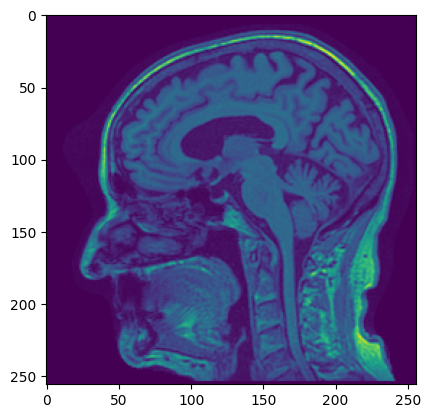

In [10]:
## Sample some of the images
adni_sample, label = train_dataset[0]
print(adni_sample.shape)
print(label) # 0 = CN, 1 = MCI, 2 = AD (Current sample is AD)
plt.imshow(adni_sample[:,:,80]) # Image is contained in a 256 x 256 image with 166 slices (MRI images)
# ax = plt.axes(projection='3d')
# ax.plot(test[0][0], test[1], 'green')
# plt.show()